In [1]:
import os
import numpy as np
from PIL import Image, ImageDraw
import torch
import torch.nn as nn
import torch.nn.modules.conv as conv
import torch.utils.data as utils
import torch.nn.functional as F
from torchsummary import summary
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from coordconv import AddCoords
from hrnet import HighResolutionNet
from config import get_cfg_defaults


In [8]:
class HRNet(nn.Module):
    def __init__(self, width):
        super(HRNet, self).__init__()
        cfg = get_cfg_defaults()
        cfg.merge_from_file("./exp.yaml")
        self.hr = HighResolutionNet(cfg)
        self.add_coords = AddCoords(rank=2)
        self.conv5 = nn.Conv2d(7, 7, 3, padding=1)
        self.conv6 = nn.Conv2d(7, 7, 3, padding=1)
        self.conv7 = nn.Conv2d(7, 4, 1)
        self.pool = nn.MaxPool2d(width, stride=width)

    def forward(self, x):
        x1 = self.hr(x)
        x1 = F.interpolate(x1, scale_factor=4)
        x = torch.cat((x, x1), dim=1)
        x = self.add_coords(x)
        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))
        x = self.conv7(x)
        x = self.pool(x)
        x = x.view(-1, 4)
        return x
m = HRNet(width=64)
# summary(m, (3, 64, 64))
x = m(torch.rand(1,1,64,64))
x.shape

torch.Size([1, 4])

In [2]:
# from models.CornerNet import model

# m = model()

class convolution(nn.Module):
    def __init__(self, k, inp_dim, out_dim, stride=1, with_bn=True):
        super(convolution, self).__init__()

        pad = (k - 1) // 2
        self.conv = nn.Conv2d(inp_dim, out_dim, (k, k), padding=(pad, pad), stride=(stride, stride), bias=not with_bn)
        self.bn   = nn.BatchNorm2d(out_dim) if with_bn else nn.Sequential()
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        conv = self.conv(x)
        bn   = self.bn(conv)
        relu = self.relu(bn)
        return relu

class residual(nn.Module):
    def __init__(self, inp_dim, out_dim, k=3, stride=1):
        super(residual, self).__init__()
        p = (k - 1) // 2

        self.conv1 = nn.Conv2d(inp_dim, out_dim, (k, k), padding=(p, p), stride=(stride, stride), bias=False)
        self.bn1   = nn.BatchNorm2d(out_dim)
        self.relu1 = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(out_dim, out_dim, (k, k), padding=(p, p), bias=False)
        self.bn2   = nn.BatchNorm2d(out_dim)
        
        self.skip  = nn.Sequential(
            nn.Conv2d(inp_dim, out_dim, (1, 1), stride=(stride, stride), bias=False),
            nn.BatchNorm2d(out_dim)
        ) if stride != 1 or inp_dim != out_dim else nn.Sequential()
        self.relu  = nn.ReLU(inplace=True)

    def forward(self, x):
        conv1 = self.conv1(x)
        bn1   = self.bn1(conv1)
        relu1 = self.relu1(bn1)

        conv2 = self.conv2(relu1)
        bn2   = self.bn2(conv2)

        skip  = self.skip(x)
        return self.relu(bn2 + skip)


pre = nn.Sequential(
            convolution(7, 3, 128, stride=2), residual(128, 256, stride=2)
        )
# pre(torch.from_numpy(np.random.rand(1, 3, 128, 128)).double())
# conv = convolution(7, 3, 128, stride=2)
x = torch.rand(1, 3, 512, 512)
x = pre(x)
# x.shape

summary(pre, (3, 400, 400))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1        [-1, 128, 200, 200]          18,816
       BatchNorm2d-2        [-1, 128, 200, 200]             256
              ReLU-3        [-1, 128, 200, 200]               0
       convolution-4        [-1, 128, 200, 200]               0
            Conv2d-5        [-1, 256, 100, 100]         294,912
       BatchNorm2d-6        [-1, 256, 100, 100]             512
              ReLU-7        [-1, 256, 100, 100]               0
            Conv2d-8        [-1, 256, 100, 100]         589,824
       BatchNorm2d-9        [-1, 256, 100, 100]             512
           Conv2d-10        [-1, 256, 100, 100]          32,768
      BatchNorm2d-11        [-1, 256, 100, 100]             512
             ReLU-12        [-1, 256, 100, 100]               0
         residual-13        [-1, 256, 100, 100]               0
Total params: 938,112
Trainable params:

In [3]:
class upsample(nn.Module):
    def __init__(self, scale_factor):
        super(upsample, self).__init__()
        self.scale_factor = scale_factor

    def forward(self, x):
        return nn.functional.interpolate(x, scale_factor=self.scale_factor)

class merge(nn.Module):
    def forward(self, x, y):
        return x + y
    
def _make_layer(inp_dim, out_dim, modules):
    layers  = [residual(inp_dim, out_dim)]
    layers += [residual(out_dim, out_dim) for _ in range(1, modules)]
    return nn.Sequential(*layers)

def _make_layer_revr(inp_dim, out_dim, modules):
    layers  = [residual(inp_dim, inp_dim) for _ in range(modules - 1)]
    layers += [residual(inp_dim, out_dim)]
    return nn.Sequential(*layers)

def _make_pool_layer(dim):
    return nn.MaxPool2d(kernel_size=2, stride=2)

def _make_unpool_layer(dim):
    return upsample(scale_factor=2)

def _make_merge_layer(dim):
    return merge()

class fire_module(nn.Module):
    def __init__(self, inp_dim, out_dim, sr=2, stride=1):
        super(fire_module, self).__init__()
        self.conv1    = nn.Conv2d(inp_dim, out_dim // sr, kernel_size=1, stride=1, bias=False)
        self.bn1      = nn.BatchNorm2d(out_dim // sr)
        self.conv_1x1 = nn.Conv2d(out_dim // sr, out_dim // 2, kernel_size=1, stride=stride, bias=False)
        self.conv_3x3 = nn.Conv2d(out_dim // sr, out_dim // 2, kernel_size=3, padding=1, 
                                  stride=stride, groups=out_dim // sr, bias=False)
        self.bn2      = nn.BatchNorm2d(out_dim)
        self.skip     = (stride == 1 and inp_dim == out_dim)
        self.relu     = nn.ReLU(inplace=True)

    def forward(self, x):
        conv1 = self.conv1(x)
        bn1   = self.bn1(conv1)
        conv2 = torch.cat((self.conv_1x1(bn1), self.conv_3x3(bn1)), 1)
        bn2   = self.bn2(conv2)
        if self.skip:
            return self.relu(bn2 + x)
        else:
            return self.relu(bn2)

class hg_module(nn.Module):
    def __init__(
        self, n, dims, modules, make_up_layer=_make_layer,
        make_pool_layer=_make_pool_layer, make_hg_layer=_make_layer,
        make_low_layer=_make_layer, make_hg_layer_revr=_make_layer_revr,
        make_unpool_layer=_make_unpool_layer, make_merge_layer=_make_merge_layer
    ):
        super(hg_module, self).__init__()

        curr_mod = modules[0]
        next_mod = modules[1]

        curr_dim = dims[0]
        next_dim = dims[1]

        self.n    = n
        self.up1  = make_up_layer(curr_dim, curr_dim, curr_mod)
        self.max1 = make_pool_layer(curr_dim)
        self.low1 = make_hg_layer(curr_dim, next_dim, curr_mod)
        self.low2 = hg_module(
            n - 1, dims[1:], modules[1:],
            make_up_layer=make_up_layer,
            make_pool_layer=make_pool_layer,
            make_hg_layer=make_hg_layer,
            make_low_layer=make_low_layer,
            make_hg_layer_revr=make_hg_layer_revr,
            make_unpool_layer=make_unpool_layer,
            make_merge_layer=make_merge_layer
        ) if n > 1 else make_low_layer(next_dim, next_dim, next_mod)
        self.low3 = make_hg_layer_revr(next_dim, curr_dim, curr_mod)
        self.up2  = make_unpool_layer(curr_dim)
        self.merg = make_merge_layer(curr_dim)

    def forward(self, x):
        up1  = self.up1(x)
        max1 = self.max1(x)
        low1 = self.low1(max1)
        low2 = self.low2(low1)
        low3 = self.low3(low2)
        up2  = self.up2(low3)
        print(up1.shape)
        print(up2.shape)
        merg = self.merg(up1, up2)
        return merg
#         return up1

    
def make_pool_layer(dim):
    return nn.Sequential()

def make_unpool_layer(dim):
    return nn.ConvTranspose2d(dim, dim, kernel_size=4, stride=2, padding=1)

def make_layer(inp_dim, out_dim, modules):
    layers  = [fire_module(inp_dim, out_dim)]
    layers += [fire_module(out_dim, out_dim) for _ in range(1, modules)]
    return nn.Sequential(*layers)

def make_layer_revr(inp_dim, out_dim, modules):
    layers  = [fire_module(inp_dim, inp_dim) for _ in range(modules - 1)]
    layers += [fire_module(inp_dim, out_dim)]
    return nn.Sequential(*layers)

def make_hg_layer(inp_dim, out_dim, modules):
    layers  = [fire_module(inp_dim, out_dim, stride=2)]
    layers += [fire_module(out_dim, out_dim) for _ in range(1, modules)]
    return nn.Sequential(*layers)

m = hg_module(
                4, [256, 256, 384, 384, 512], [2, 2, 2, 2, 4],
                make_pool_layer=make_pool_layer,
                make_unpool_layer=make_unpool_layer,
                make_up_layer=make_layer,
                make_low_layer=make_layer,
                make_hg_layer_revr=make_layer_revr,
                make_hg_layer=make_hg_layer
            )

summary(m, (256, 256, 256))
# m(torch.rand(1, 256, 100, 100))

torch.Size([2, 384, 32, 32])
torch.Size([2, 384, 32, 32])
torch.Size([2, 384, 64, 64])
torch.Size([2, 384, 64, 64])
torch.Size([2, 256, 128, 128])
torch.Size([2, 256, 128, 128])
torch.Size([2, 256, 256, 256])
torch.Size([2, 256, 256, 256])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1        [-1, 128, 256, 256]          32,768
       BatchNorm2d-2        [-1, 128, 256, 256]             256
            Conv2d-3        [-1, 128, 256, 256]          16,384
            Conv2d-4        [-1, 128, 256, 256]           1,152
       BatchNorm2d-5        [-1, 256, 256, 256]             512
              ReLU-6        [-1, 256, 256, 256]               0
       fire_module-7        [-1, 256, 256, 256]               0
            Conv2d-8        [-1, 128, 256, 256]          32,768
       BatchNorm2d-9        [-1, 128, 256, 256]             256
           Conv2d-10        [-1, 128, 256, 256]        

In [5]:
def _pred_mod(dim):
        return nn.Sequential(
            convolution(1, 256, 256, with_bn=False),
            nn.Conv2d(256, dim, (1, 1))
        )
m = _pred_mod(80)
summary(m, (256, 200, 200))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1        [-1, 256, 200, 200]          65,792
              ReLU-2        [-1, 256, 200, 200]               0
       convolution-3        [-1, 256, 200, 200]               0
            Conv2d-4         [-1, 80, 200, 200]          20,560
Total params: 86,352
Trainable params: 86,352
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 39.06
Forward/backward pass size (MB): 258.79
Params size (MB): 0.33
Estimated Total Size (MB): 298.18
----------------------------------------------------------------


In [10]:
from models.py_utils import TopPool, LeftPool

class corner_pool(nn.Module):
    def __init__(self, dim, pool1, pool2):
        super(corner_pool, self).__init__()
        self._init_layers(dim, pool1, pool2)

    def _init_layers(self, dim, pool1, pool2):
        self.p1_conv1 = convolution(3, dim, 128)
        self.p2_conv1 = convolution(3, dim, 128)

        self.p_conv1 = nn.Conv2d(128, dim, (3, 3), padding=(1, 1), bias=False)
        self.p_bn1   = nn.BatchNorm2d(dim)

        self.conv1 = nn.Conv2d(dim, dim, (1, 1), bias=False)
        self.bn1   = nn.BatchNorm2d(dim)
        self.relu1 = nn.ReLU(inplace=True)

        self.conv2 = convolution(3, dim, dim)

        self.pool1 = pool1()
        self.pool2 = pool2()

    def forward(self, x):
        # pool 1
        p1_conv1 = self.p1_conv1(x)
        pool1    = self.pool1(p1_conv1)

        # pool 2
        p2_conv1 = self.p2_conv1(x)
        pool2    = self.pool2(p2_conv1)

        # pool 1 + pool 2
        p_conv1 = self.p_conv1(pool1 + pool2)
        p_bn1   = self.p_bn1(p_conv1)

        conv1 = self.conv1(x)
        bn1   = self.bn1(conv1)
        relu1 = self.relu1(p_bn1 + bn1)

        conv2 = self.conv2(relu1)
        return conv2

m = corner_pool(256, TopPool, LeftPool)
summary(m, (256, 100, 100))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1        [-1, 128, 100, 100]         294,912
       BatchNorm2d-2        [-1, 128, 100, 100]             256
              ReLU-3        [-1, 128, 100, 100]               0
       convolution-4        [-1, 128, 100, 100]               0
           TopPool-5        [-1, 128, 100, 100]               0
            Conv2d-6        [-1, 128, 100, 100]         294,912
       BatchNorm2d-7        [-1, 128, 100, 100]             256
              ReLU-8        [-1, 128, 100, 100]               0
       convolution-9        [-1, 128, 100, 100]               0
         LeftPool-10        [-1, 128, 100, 100]               0
           Conv2d-11        [-1, 256, 100, 100]         294,912
      BatchNorm2d-12        [-1, 256, 100, 100]             512
           Conv2d-13        [-1, 256, 100, 100]          65,536
      BatchNorm2d-14        [-1, 256, 1

In [13]:
class SimpleNet(nn.Module):
    def __init__(self, width):
        super(SimpleNet, self).__init__()
        self.width = width
        self.add_coords = AddCoords(rank=2)
        self.conv1 = nn.Conv2d(3, 8, 3, padding=1)
        self.conv2 = nn.Conv2d(8, 16, 3, padding=1)
        self.conv3 = nn.Conv2d(16, 32, 3, padding=1)
        self.pool = corner_pool(32, TopPool, LeftPool)
        self.conv4 = nn.Conv2d(32, 1, 1)
        self.conv5 = nn.Conv2d(1, 1, 1)

    def forward(self, x):
        # x: (N, C_in, H, W)
        x = self.add_coords(x)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        x = F.relu(self.conv4(x))
        x = self.conv5(x)
        return x

m = SimpleNet(width=3)
summary(m, (1, 3, 3))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         AddCoords-1              [-1, 3, 3, 3]               0
            Conv2d-2              [-1, 8, 3, 3]             224
            Conv2d-3             [-1, 16, 3, 3]           1,168
            Conv2d-4             [-1, 32, 3, 3]           4,640
            Conv2d-5            [-1, 128, 3, 3]          36,864
       BatchNorm2d-6            [-1, 128, 3, 3]             256
              ReLU-7            [-1, 128, 3, 3]               0
       convolution-8            [-1, 128, 3, 3]               0
           TopPool-9            [-1, 128, 3, 3]               0
           Conv2d-10            [-1, 128, 3, 3]          36,864
      BatchNorm2d-11            [-1, 128, 3, 3]             256
             ReLU-12            [-1, 128, 3, 3]               0
      convolution-13            [-1, 128, 3, 3]               0
         LeftPool-14            [-1, 12

In [102]:
import itertools

# def norm(x, width):
#     return x * width

def norm(x, width):
    return (int)(x * (width - 1) + 0.5)

def _draw_rect(points, width=64):
    x0, y0, x1, y1 = points
    print(x0, y0, x1, y1)
    x0 = norm(x0, width)
    y0 = norm(y0, width)
    x1 = norm(x1, width)
    y1 = norm(y1, width)
#     if (x1 == 1):
#         x1 -= 0.1
#     if (y1 == 1):
#         y1 -= 0.1
    print(x0, y0, x1, y1)
    im = Image.new("F", (width, width))
    draw = ImageDraw.Draw(im)
    draw.rectangle([x0, y0, x1, y1], fill=1, outline=None, width=0)
    im = np.array(im)  # (H, W)
    print(im)
    im = np.expand_dims(im, axis=-1)  # (H, W, 1)
    return im

def draw_rect(xy, width=3):
    x0, y0, x1, y1 = xy
    rect = np.zeros()
    

width = 3
xy = []
for x0, y0 in itertools.product(range(width), range(width)):
    for _w, _h in itertools.product(range(1, width - x0 + 1), range(1, width-y0+1)):
        x1 = x0 + _w
        y1 = y0 + _h
        xy.append([x0, y0, x1, y1])
#         x = np.array([x0, y0, x1, y1], dtype=float)
#         x /= width
#         draw_rect(x, width)
        
for (x0, y0, x1, y1) in xy:
    rect = np.zeros((width, width))
    for i, j in itertools.product(range(x0, x1), range(y0, y1)):
        rect[i][j] = 1.
#     print(rect)

# x = np.array([1,2], dtype=int)
# x = x.astype(float) / 2
x = np.stack([np.array([1,2]), np.array([3,4]), np.array([3,4])])
len(x)

def draw_l2_distance(x, y, width=64):
    im = np.zeros((width, width), dtype=float)
    for (i, j), _ in np.ndenumerate(im):
        im[i][j] = -np.linalg.norm(np.array([x, y]) - np.array([i, j])) / width
#     im = im.transpose(1, 0).reshape(width * width)  # (W, H) -> (H, W) -> (H*W)
    return im

draw_l2_distance(1, 2, width=3)

array([[-0.74535599, -0.47140452, -0.33333333],
       [-0.66666667, -0.33333333, -0.        ],
       [-0.74535599, -0.47140452, -0.33333333]])

In [120]:
x0 = torch.rand(1,3,100, 100)
m = nn.MaxPool2d(2)
x1 = m(x0)
x1 = F.interpolate(x1, scale_factor=2)
# x = torch.cat((x0, x1), dim=1)
x.shape

torch.Size([1, 6, 100, 100])

Generating datasets...
2
2


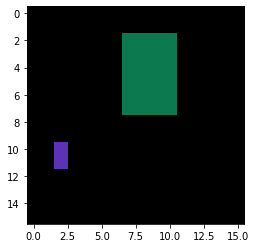

In [108]:
def draw_rect_pil(xy, width=64):
    x0, y0, x1, y1 = xy
    x1 -= 0.5
    y1 -= 0.5
    im = Image.new("F", (width, width))
    draw = ImageDraw.Draw(im)
    draw.rectangle([x0, y0, x1, y1], fill=1)
    im = np.array(im)  # (H, W)
    return im


def rand_draw(draw_fn=draw_rect_pil, n_strokes=2, width=64):
    canvas = np.zeros((width, width, 3), dtype=np.int8)
    im = [canvas.copy()]
    x = []
    for _ in range(n_strokes):
        x0, y0 = np.random.randint(width, size=2)
        x1 = x0 + np.random.randint(1, width - x0 + 1)
        y1 = y0 + np.random.randint(1, width - y0 + 1)
        _x = np.array((x0, y0, x1, y1))
        #         _x = np.random.rand(action_dim)
        color = np.random.randint(255, size=(3))  # (3)
        #         x.append(np.concatenate((_x, color / 255.0)))
        stroke = draw_fn(_x, width)  # (w, w)
        stroke = np.expand_dims(stroke, axis=2)  # (w, w, 1)
        canvas = canvas * (1 - stroke) + stroke * color  # (w, h, 3)
        x.append(_x)
        im.append(canvas.copy())
    x = np.stack(x) / width  # (n_strokes, action_dim+3)
    im = np.stack(im)
    return x, im

def generate_data(width=128, n_sample=1000, n_strokes=2):
    print("Generating datasets...")
    if not os.path.exists("data-rect/"):
        os.makedirs("data-rect/")

    x, im = [], []
    for _ in range(n_sample):
        _x, _im = rand_draw(n_strokes=n_strokes, width=width)
        _im_inter = _im[:-1]
        _im_target = _im[-1]
#         print(_im_inter.shape)
        for i in range(n_strokes):
            im.append(np.concatenate((_im_inter[i], _im_target), axis=2))
            x.append(_x[i])
    print(len(x))
    print(len(im))
#     print(im[0][:,:,-3:])
#     plt.imshow(Image.fromarray(im[1][:,:,:-3].astype('uint8')))
    plt.imshow(Image.fromarray(im[1][:,:,-3:].astype('uint8')))

generate_data(width=16, n_sample=1, n_strokes=2)
# a = np.array([1,2,3])
# a = np.random.rand(5,3)
# b = np.array([3,4,5])
# b = np.random.rand(5,3)
# np.concatenate([a,b],axis=1).shape
# x[:-1]

# x, im = rand_draw()
# fig, ax = plt.subplots(1,3)
# ax[0].imshow(Image.fromarray(im[0].astype(np.uint8)))
# ax[1].imshow(Image.fromarray(im[1].astype(np.uint8)))
# ax[2].imshow(Image.fromarray(im[2].astype(np.uint8)))
# fig.show()



In [13]:
class Regressor(nn.Module):
    def __init__(self, in_channel, width, out_size=4, latent_size=128):
        super(Regressor, self).__init__()
        self.add_coords = AddCoords(rank=2)
#         self.conv0 = nn.Conv2d(in_channel + 2, latent_size, 3, padding=1)
#         self.bn0 = BatchNorm2d(latent_size)
#         self.conv1 = nn.Conv2d(latent_size, latent_size, 3, padding=1)
#         self.bn1 = BatchNorm2d(latent_size)
# self.conv2 = nn.Conv2d(latent_size, out_size, 1)
        self.conv0 = nn.Conv2d(in_channel + 2, latent_size, 1, stride=1, padding=0)
        self.bn0 = nn.BatchNorm2d(latent_size)
        self.conv2 = nn.Conv2d(latent_size, out_size, 1, stride=1, padding=0)
        self.pool = nn.MaxPool2d(width, stride=width)

    def forward(self, x):
        x = self.add_coords(x)
        x = self.conv0(x)
        x = F.relu(self.bn0(x))
#         x = F.relu(self.conv1(x))
        x = self.conv2(x)
        x = self.pool(x)
        x = x.view(-1, 4)
        return x
    
class HRNet(nn.Module):
    def __init__(self, width):
        super(HRNet, self).__init__()
        cfg = get_cfg_defaults()
        cfg.merge_from_file("./hrnet.yaml")
        self.hr0 = HighResolutionNet(cfg)
        self.hr1 = HighResolutionNet(cfg)
        self.rg = Regressor(in_channel=540, width=int(width/4))
        
    def forward(self, im_current, im_target):
        x0 = self.hr0(im_current)
        x1 = self.hr1(im_target)
        x = torch.cat((x0, x1), dim=1)
        x = self.rg(x)
        return x

class Painter(nn.Module):
    def __init__(self, in_dim=128, out_dim=4, hidden_dim=128):
        super(Painter, self).__init__()
        self.lstm = nn.LSTM(in_dim, hidden_dim)
        self.fc0 = nn.Linear(hidden_dim, out_dim)

    def forward(self, x):
        x, _ = self.lstm(x)
        return x

    
m = HRNet(64)
x0 = torch.rand(1,3,64,64)
x1 = torch.rand(1,3,64,64)
m(x0, x1).shape

# summary(m, (1, 128))

# rnn = nn.GRU(10, 20)
# input = torch.randn(5, 3, 10)
# h0 = torch.randn(2, 3, 20)
# # output, hn = rnn(input, h0)
# output, hn = rnn(input)
# print(output.shape)
# print(hn.shape)


# summary(rnn, (3, 10))

torch.Size([1, 4])